# **Movie Genre Detection**

**Importing Library**

In [ ]:
#Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

**Loading Data**

In [ ]:
# Load the training data

train_path = "/content/train_data.txt"
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
train_data.head(3)

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...


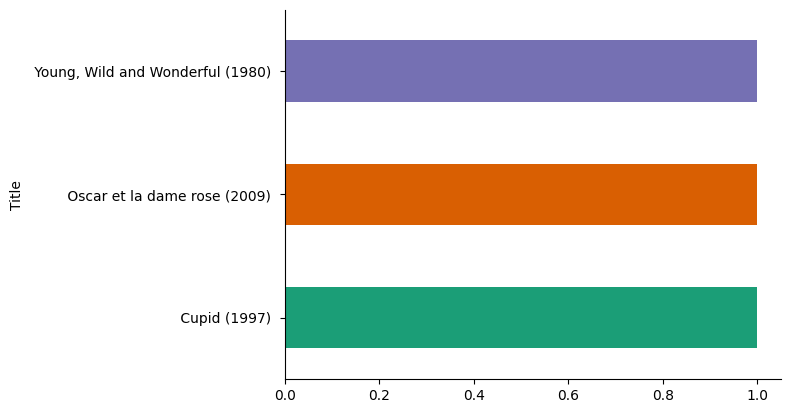

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Load the test data

test_path = "/content/test_data.txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_data.head(3)

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...


In [ ]:
test_soln_path = "/content/test_data_solution.txt"
test_soln_data = pd.read_csv(test_soln_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_soln_data.drop(test_soln_data.columns[[0, 2]], axis=1, inplace=True)
test_soln_data.rename(columns = {'Title':'Actual Genre'}, inplace = True)
test_soln_data.head(3)

,Actual Genre
1,thriller
2,comedy
3,documentary


**Visualization**

In [ ]:
#Count each genre value
train_data.Genre.value_counts()

 drama           4389
 documentary     4231
 comedy          2399
 short           1690
 horror           693
 thriller         518
 action           419
 western          339
 reality-tv       293
 family           272
 adventure        262
 music            243
 sci-fi           221
 romance          213
 adult            189
 animation        170
 crime            135
 sport            129
 talk-show        128
 fantasy          111
 mystery          104
 musical           86
 biography         77
 history           75
 game-show         64
 news              58
 war               44
Name: Genre, dtype: int64

<ipython-input-10-3b418856404e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts, palette='mako')


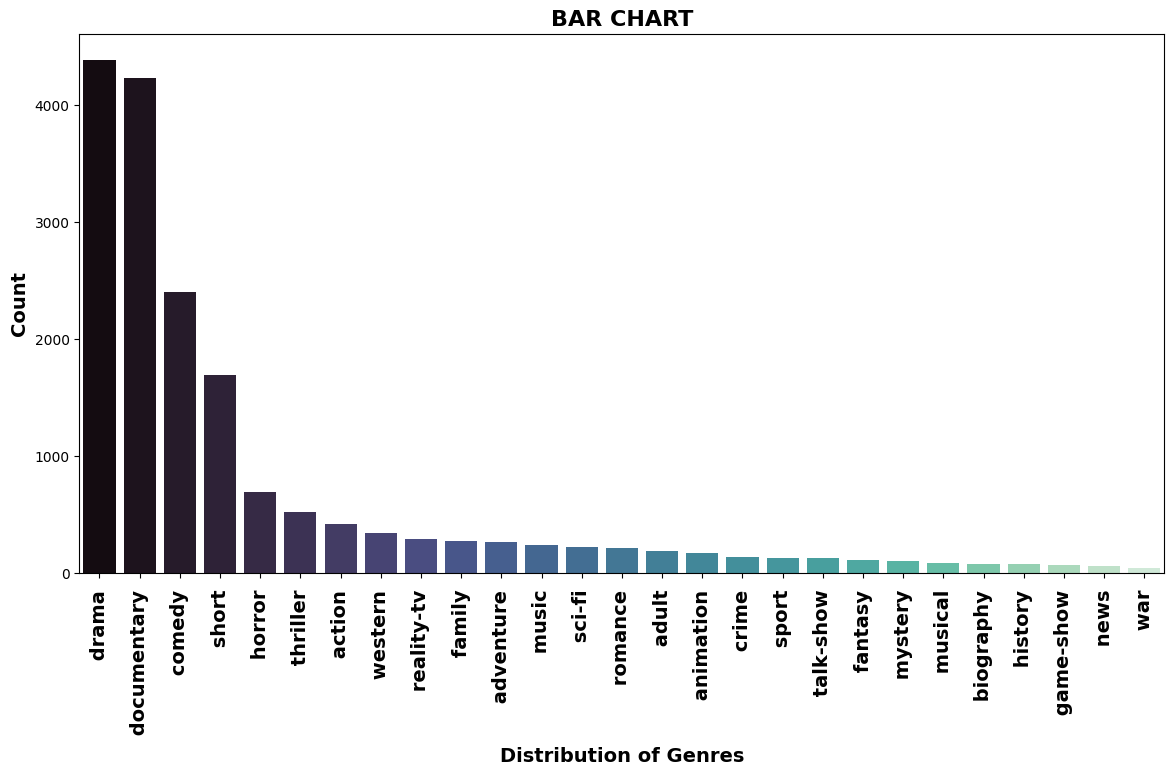

In [ ]:
# Plot the distribution of genres using a bar plot
plt.figure(figsize=(14, 7))
counts = train_data['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='mako')
plt.xlabel('Distribution of Genres', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('BAR CHART', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()

**Data Preprocessing**

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17552 entries, 1 to 17552
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        17552 non-null  object
 1   Genre        17552 non-null  object
 2   Description  17552 non-null  object
dtypes: object(3)
memory usage: 548.5+ KB


In [ ]:
#Find null value
train_data.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

In [ ]:
# Dropping the redundant data

train_data = train_data.drop_duplicates()
print("shape",train_data.shape)

shape (17552, 4)


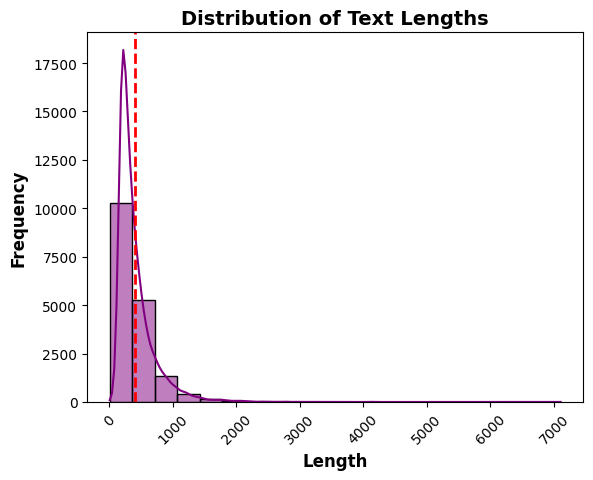

In [ ]:
plt.title('Distribution of Text Lengths', fontsize=14, fontweight='bold')
plt.xlabel('Length', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')

sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='purple', alpha=0.5)
plt.xticks(rotation=45)
mean_length = train_data['length_Text_cleaning'].mean()
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=2)
plt.show()

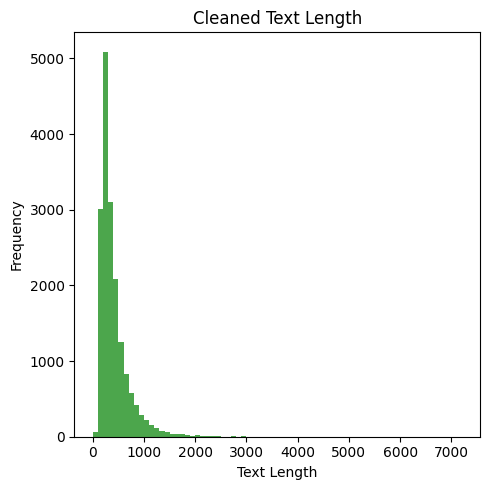

In [ ]:
# Set up the figure with two subplots
plt.figure(figsize=(5, 5))

#  Cleaned text length distribution

cleaned_lengths = train_data['Text_cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='green', alpha=0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

**Text Vectorization (TF-IDF)**

In [ ]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

# Transform the test data
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

In [ ]:
#Split data into train and test data
X = X_train
y = train_data["Genre"]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

**SVM**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Initialize and train a Support Vector Classifier
clf_svc = SVC()
clf_svc.fit(X_train, Y_train)

# Make predictions on the validation set
y_pred = clf_svc.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(Y_test, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(Y_test, y_pred))

Validation Accuracy: 0.5012816861293079
               precision    recall  f1-score   support

      action        0.00      0.00      0.00        96
       adult        0.00      0.00      0.00        35
   adventure        1.00      0.02      0.03        58
   animation        0.00      0.00      0.00        31
   biography        0.00      0.00      0.00        15
      comedy        0.51      0.40      0.45       464
       crime        0.00      0.00      0.00        32
 documentary        0.57      0.91      0.70       846
       drama        0.43      0.82      0.56       893
      family        0.00      0.00      0.00        45
     fantasy        0.00      0.00      0.00        25
   game-show        1.00      0.17      0.29        12
     history        0.00      0.00      0.00        12
      horror        0.81      0.20      0.32       148
       music        1.00      0.06      0.12        48
     musical        0.00      0.00      0.00        14
     mystery        0.00

In [ ]:
accuracy_svc = accuracy_score(Y_test, y_pred)
accuracy_svc

0.5012816861293079

**Naive Bayes**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Initialize and train a Support Vector Classifier
clf_NB = MultinomialNB()
clf_NB.fit(X_train, Y_train)

# Make predictions on the validation set
y_pred = clf_NB.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(Y_test, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(Y_test, y_pred))

Validation Accuracy: 0.4386214753631444
               precision    recall  f1-score   support

      action        0.00      0.00      0.00        96
       adult        0.00      0.00      0.00        35
   adventure        0.00      0.00      0.00        58
   animation        0.00      0.00      0.00        31
   biography        0.00      0.00      0.00        15
      comedy        0.80      0.02      0.03       464
       crime        0.00      0.00      0.00        32
 documentary        0.54      0.90      0.67       846
       drama        0.37      0.86      0.52       893
      family        0.00      0.00      0.00        45
     fantasy        0.00      0.00      0.00        25
   game-show        0.00      0.00      0.00        12
     history        0.00      0.00      0.00        12
      horror        0.00      0.00      0.00       148
       music        0.00      0.00      0.00        48
     musical        0.00      0.00      0.00        14
     mystery        0.00

In [ ]:
accuracy_NB = accuracy_score(Y_test, y_pred)
accuracy_NB

0.4386214753631444

**Logistic Regression**

In [ ]:
# Initialize and train a Logistic Regression Classifier
clf_logreg = LogisticRegression(multi_class='multinomial', solver='sag')
clf_logreg.fit(X_train, Y_train)

# Make predictions on the validation set
y_pred = clf_logreg.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(Y_test, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(Y_test, y_pred))

Validation Accuracy: 0.5160922814013101
               precision    recall  f1-score   support

      action        0.00      0.00      0.00        96
       adult        0.00      0.00      0.00        35
   adventure        1.00      0.02      0.03        58
   animation        0.00      0.00      0.00        31
   biography        0.00      0.00      0.00        15
      comedy        0.47      0.50      0.48       464
       crime        0.00      0.00      0.00        32
 documentary        0.58      0.89      0.71       846
       drama        0.46      0.78      0.58       893
      family        0.00      0.00      0.00        45
     fantasy        0.00      0.00      0.00        25
   game-show        1.00      0.08      0.15        12
     history        0.00      0.00      0.00        12
      horror        0.84      0.28      0.42       148
       music        0.67      0.12      0.21        48
     musical        0.00      0.00      0.00        14
     mystery        0.00

In [ ]:
accuracy_logreg = accuracy_score(Y_test, y_pred)
accuracy_logreg

0.5160922814013101

**Comparison between SVM, Naive Bayes and Logistic Regression**

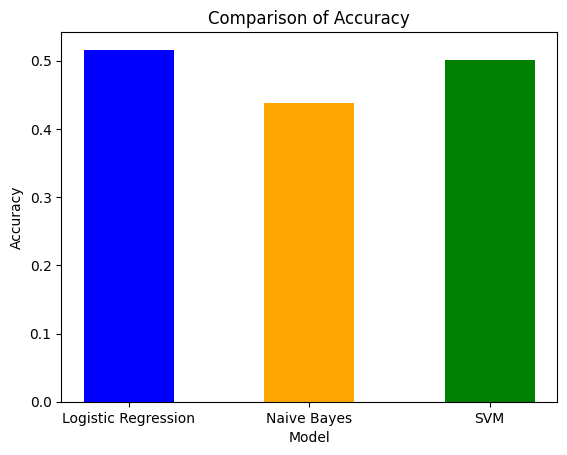

In [ ]:
# Create a bar chart with different colors for each model
plt.bar('Logistic Regression', accuracy_logreg, color='blue', width=0.5)
plt.bar('Naive Bayes', accuracy_NB, color='orange', width=0.5)
plt.bar('SVM', accuracy_svc, color='green', width=0.5)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy')

# Show the plot
plt.show()